# Pilot Experiment: LLM Tool Overreliance in Maze Navigation

This notebook runs a pilot experiment to study how LLMs rely on external tools when navigating mazes.

**Research Question**: Do LLMs over-trust noisy tools, or do they adapt their behavior based on tool reliability?

In [ ]:
import os
# API key should be set via environment variables, not hardcoded
# os.environ["OPENAI_API_KEY"] = "your-api-key-here"

# Setup
import sys
from pathlib import Path

# Add parent directory to path
sys.path.insert(0, str(Path.cwd().parent))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from config_loader import ConfigLoader
from envs.grid_world import GridWorld, GridWorldConfig
from tools.astar_planner import AStarPlanner
from tools.noise_models import NoiseFactory
from agents.base_agent import MazeAgent, AgentConfig
from agents.strategies import AdaptiveStrategy
from experiments.runner import ExperimentConfig, ExperimentRunner
from experiments.metrics import MetricsCollector

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("Imports successful!")

## 1. Basic Environment Setup

Let's start by exploring the GridWorld environment and visualizing a maze.

In [9]:
# Create a simple maze environment
env_config = GridWorldConfig(
    maze_size=12,
    difficulty="medium",
    seed=42,
    max_steps=300
)

env = GridWorld(env_config)
obs, info = env.reset()

print(f"Maze size: {env.config.maze_size}x{env.config.maze_size}")
print(f"Agent position: {obs['agent_pos']}")
print(f"Goal position: {obs['goal_pos']}")
print(f"Maze obstacles: {np.sum(obs['maze'])} walls")

Maze size: 12x12
Agent position: [0 0]
Goal position: [11 11]
Maze obstacles: 62 walls


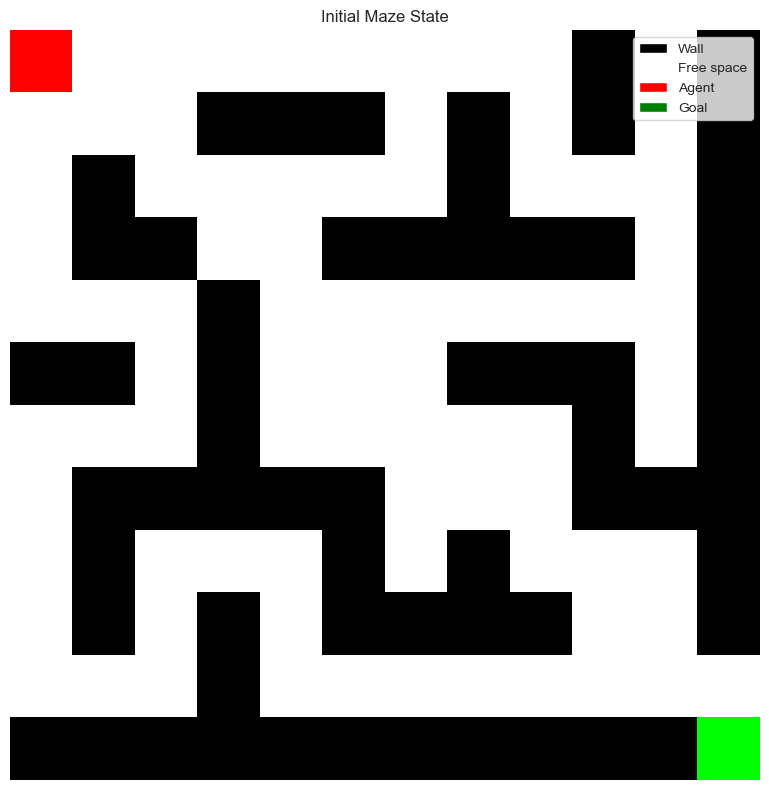

In [10]:
# Visualize the maze
def visualize_maze(env, title="Maze"):
    """Visualize maze with agent and goal."""
    rgb = env.render()
    
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb)
    plt.title(title)
    plt.axis('off')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='black', label='Wall'),
        Patch(facecolor='white', label='Free space'),
        Patch(facecolor='red', label='Agent'),
        Patch(facecolor='green', label='Goal')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.tight_layout()
    plt.show()

visualize_maze(env, "Initial Maze State")

## 2. A* Planner with Noise Injection

Let's test the A* planner and see how noise affects its suggestions.

In [11]:
# Get optimal path
optimal_path = env.get_optimal_path()
print(f"Optimal path length: {len(optimal_path)} steps")
print(f"First 5 steps: {optimal_path[:5]}")

# Test planner without noise
planner_perfect = AStarPlanner(noise_model=None, seed=42)
path_perfect = planner_perfect.plan(
    env.maze,
    tuple(obs['agent_pos']),
    tuple(obs['goal_pos'])
)
print(f"\nPerfect planner path length: {len(path_perfect)}")
print(f"Paths match: {path_perfect == optimal_path}")

Optimal path length: 23 steps
First 5 steps: [(0, 0), (1, 0), (1, 1), (1, 2), (2, 2)]

Perfect planner path length: 23
Paths match: True


In [12]:
# Test planner with different noise types
noise_types = ["none", "random", "biased", "delayed"]
noise_results = {}

for noise_type in noise_types:
    noise_model = NoiseFactory.create(noise_type, noise_level=0.3)
    planner = AStarPlanner(noise_model=noise_model, seed=42)
    
    # Get multiple suggestions to see variance
    paths = []
    for _ in range(5):
        path = planner.plan(
            env.maze,
            tuple(obs['agent_pos']),
            tuple(obs['goal_pos'])
        )
        if path:
            paths.append(len(path))
    
    noise_results[noise_type] = {
        "avg_length": np.mean(paths) if paths else 0,
        "std_length": np.std(paths) if paths else 0,
        "optimal_length": len(optimal_path)
    }

# Display results
df_noise = pd.DataFrame(noise_results).T
print("\nNoise Type Comparison:")
print(df_noise.round(2))


Noise Type Comparison:
         avg_length  std_length  optimal_length
none           23.0         0.0            23.0
random         23.0         0.0            23.0
biased         18.6         8.8            23.0
delayed        23.0         0.0            23.0


## 3. Single Episode with Different Strategies

Let's run a single maze navigation episode with different agent strategies.

In [13]:
def run_single_episode(
    maze_size=12,
    difficulty="medium",
    strategy="adaptive",
    noise_type="random",
    noise_level=0.3,
    seed=42
):
    """Run a single episode and return metrics."""
    
    # Create environment
    env_config = GridWorldConfig(
        maze_size=maze_size,
        difficulty=difficulty,
        seed=seed,
        max_steps=500
    )
    env = GridWorld(env_config)
    obs, info = env.reset()
    
    # Create planner
    noise_model = NoiseFactory.create(noise_type, noise_level)
    planner = AStarPlanner(noise_model=noise_model, seed=seed)
    
    # Create agent
    agent_config = AgentConfig(
        model="gpt-4-turbo",
        strategy=strategy,
        seed=seed
    )
    
    if strategy == "adaptive":
        strat = AdaptiveStrategy(initial_trust=0.5)
    elif strategy == "tool_trusting":
        from agents.strategies import ToolTrustingStrategy
        strat = ToolTrustingStrategy()
    elif strategy == "tool_avoiding":
        from agents.strategies import ToolAvoidingStrategy
        strat = ToolAvoidingStrategy()
    
    agent = MazeAgent(agent_config, planner=planner, strategy=strat)
    
    # Run episode
    done = False
    success = False
    while not done:
        action = agent.step(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        if terminated:
            success = True
    
    # Get optimal path
    optimal_path = env.get_optimal_path()
    optimal_length = len(optimal_path) if optimal_path else float('inf')
    
    return {
        "strategy": strategy,
        "noise_type": noise_type,
        "noise_level": noise_level,
        "success": success,
        "steps": len(agent.episode_trajectory),
        "optimal_steps": optimal_length,
        "tool_queries": len(agent.tool_queries),
        "path_optimality": optimal_length / len(agent.episode_trajectory) if len(agent.episode_trajectory) > 0 else 0
    }

# Test different strategies
results = []
for strategy in ["adaptive", "tool_trusting", "tool_avoiding"]:
    for noise_level in [0.0, 0.3, 0.6]:
        result = run_single_episode(
            strategy=strategy,
            noise_type="random",
            noise_level=noise_level,
            seed=42
        )
        results.append(result)

df_episodes = pd.DataFrame(results)
print("\nSingle Episode Results:")
print(df_episodes.to_string())


Single Episode Results:
        strategy noise_type  noise_level  success  steps  optimal_steps  tool_queries  path_optimality
0       adaptive     random          0.0    False    500             23           241         0.046000
1       adaptive     random          0.3    False    500             23           241         0.046000
2       adaptive     random          0.6    False    500             23           241         0.046000
3  tool_trusting     random          0.0     True     44              1            25         0.022727
4  tool_trusting     random          0.3     True     54              1            28         0.018519
5  tool_trusting     random          0.6     True    118              1            62         0.008475
6  tool_avoiding     random          0.0    False    500             23           241         0.046000
7  tool_avoiding     random          0.3    False    500             23           241         0.046000
8  tool_avoiding     random          0.6    Fals

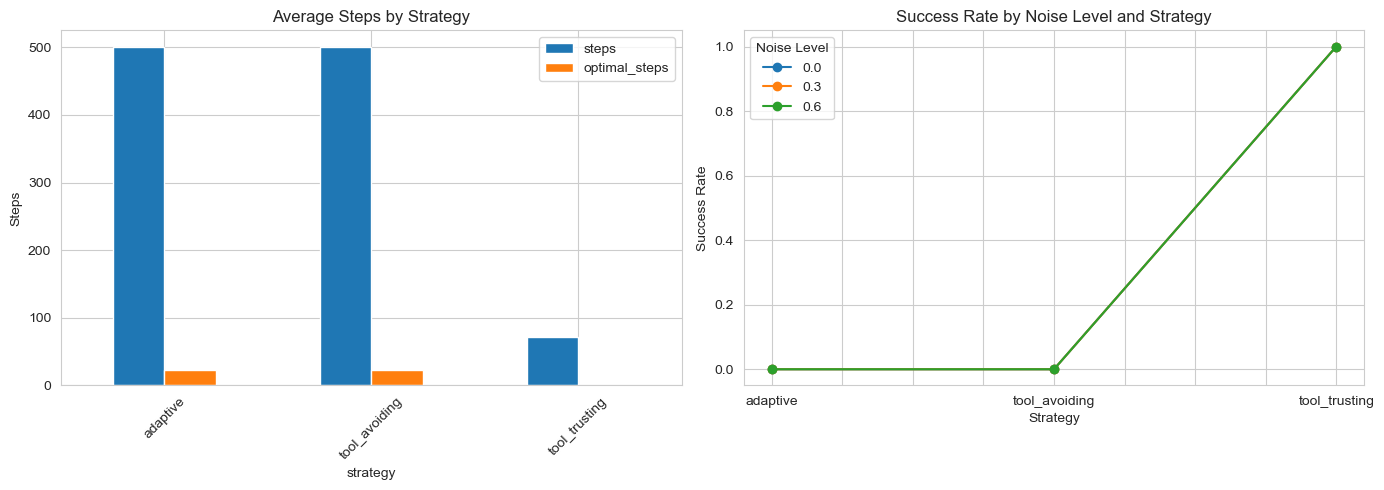

In [14]:
# Visualize strategy comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Steps by strategy
df_grouped = df_episodes.groupby('strategy')[['steps', 'optimal_steps']].mean()
df_grouped.plot(kind='bar', ax=axes[0])
axes[0].set_title('Average Steps by Strategy')
axes[0].set_ylabel('Steps')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Success rate by noise level
success_by_noise = df_episodes.groupby(['strategy', 'noise_level'])['success'].mean().unstack()
success_by_noise.plot(kind='line', marker='o', ax=axes[1])
axes[1].set_title('Success Rate by Noise Level and Strategy')
axes[1].set_ylabel('Success Rate')
axes[1].set_xlabel('Strategy')
axes[1].legend(title='Noise Level')

plt.tight_layout()
plt.show()

## 4. Full Experiment Run

Let's run a complete experiment with multiple episodes to gather statistics.

In [15]:
# Configure and run experiment
config = ExperimentConfig(
    maze_size=14,
    maze_difficulty="medium",
    num_episodes=5,  # Small number for pilot
    model="gpt-4-turbo",
    agent_strategy="adaptive",
    temperature=0.7,
    use_tool=True,
    noise_type="random",
    noise_level=0.3,
    tool_query_frequency=0.5,
    seed=42,
    max_steps_per_episode=300
)

print(f"Running experiment with config:")
print(f"  Episodes: {config.num_episodes}")
print(f"  Strategy: {config.agent_strategy}")
print(f"  Noise: {config.noise_type} (level={config.noise_level})")
print()

runner = ExperimentRunner(config)
results = runner.run()

print("\nExperiment Complete!")
print(f"Experiment ID: {results['experiment_id']}")

Running experiment with config:
  Episodes: 5
  Strategy: adaptive
  Noise: random (level=0.3)

2025-11-11 16:37:22 [info     ] experiment_start               config={'maze_size': 14, 'maze_difficulty': 'medium', 'num_episodes': 5, 'model': 'gpt-4-turbo', 'agent_strategy': 'adaptive', 'temperature': 0.7, 'use_tool': True, 'noise_type': 'random', 'noise_level': 0.3, 'tool_query_frequency': 0.5, 'seed': 42, 'max_steps_per_episode': 300} experiment_id=exp_22d1c78b
2025-11-11 16:37:22 [info     ] episode_start                  episode_id=exp_22d1c78b_ep0 episode_num=0
2025-11-11 16:37:22 [info     ] episode_complete               episode_id=exp_22d1c78b_ep0 steps=300 success=False
2025-11-11 16:37:22 [info     ] episode_start                  episode_id=exp_22d1c78b_ep1 episode_num=1
2025-11-11 16:37:22 [info     ] episode_complete               episode_id=exp_22d1c78b_ep1 steps=300 success=False
2025-11-11 16:37:22 [info     ] episode_start                  episode_id=exp_22d1c78b_ep2 epi

In [16]:
# Display results
metrics = results['metrics']

print("\nAggregated Metrics:")
print(f"  Success Rate: {metrics['success_rate']:.1%}")
print(f"  Average Steps: {metrics['avg_steps']:.1f}")
print(f"  Median Steps: {metrics['median_steps']:.1f}")
print(f"  Path Optimality: {metrics['avg_path_optimality']:.3f}")
print(f"  Tool Usage Rate: {metrics['avg_tool_usage_rate']:.1%}")
print(f"  Tool Accuracy: {metrics['avg_tool_accuracy']:.1%}")
print(f"  Tool Following Rate: {metrics['avg_tool_following_rate']:.1%}")
print(f"  Duration: {metrics['duration_seconds']:.2f}s")


Aggregated Metrics:
  Success Rate: 0.0%
  Average Steps: 299.0
  Median Steps: 299.0
  Path Optimality: 0.060
  Tool Usage Rate: 50.2%
  Tool Accuracy: 0.0%
  Tool Following Rate: 0.1%
  Duration: 0.20s


## 5. Comparative Analysis: Strategy × Noise

Run a factorial experiment comparing all combinations of strategies and noise levels.

In [17]:
# Run factorial experiment
strategies = ["adaptive", "tool_trusting", "tool_avoiding"]
noise_levels = [0.0, 0.3, 0.6]
experiment_results = []

total_runs = len(strategies) * len(noise_levels)
current_run = 0

for strategy in strategies:
    for noise_level in noise_levels:
        current_run += 1
        print(f"\nRun {current_run}/{total_runs}: {strategy} + noise={noise_level}")
        
        config = ExperimentConfig(
            maze_size=12,
            maze_difficulty="medium",
            num_episodes=3,  # Small for pilot
            agent_strategy=strategy,
            noise_level=noise_level,
            seed=42 + (len(noise_levels) * strategies.index(strategy) + noise_levels.index(noise_level))
        )
        
        runner = ExperimentRunner(config)
        results = runner.run()
        
        results['metrics']['strategy'] = strategy
        results['metrics']['noise_level'] = noise_level
        experiment_results.append(results['metrics'])

df_factorial = pd.DataFrame(experiment_results)
print("\nFactorial Experiment Complete!")


Run 1/9: adaptive + noise=0.0
2025-11-11 16:37:24 [info     ] experiment_start               config={'maze_size': 12, 'maze_difficulty': 'medium', 'num_episodes': 3, 'model': 'gpt-4-turbo', 'agent_strategy': 'adaptive', 'temperature': 0.7, 'use_tool': True, 'noise_type': 'random', 'noise_level': 0.0, 'tool_query_frequency': 0.5, 'seed': 42, 'max_steps_per_episode': 500} experiment_id=exp_42700281
2025-11-11 16:37:24 [info     ] episode_start                  episode_id=exp_42700281_ep0 episode_num=0
2025-11-11 16:37:24 [info     ] episode_complete               episode_id=exp_42700281_ep0 steps=500 success=False
2025-11-11 16:37:24 [info     ] episode_start                  episode_id=exp_42700281_ep1 episode_num=1
2025-11-11 16:37:24 [info     ] episode_complete               episode_id=exp_42700281_ep1 steps=22 success=True
2025-11-11 16:37:24 [info     ] episode_start                  episode_id=exp_42700281_ep2 episode_num=2
2025-11-11 16:37:24 [info     ] episode_complete        

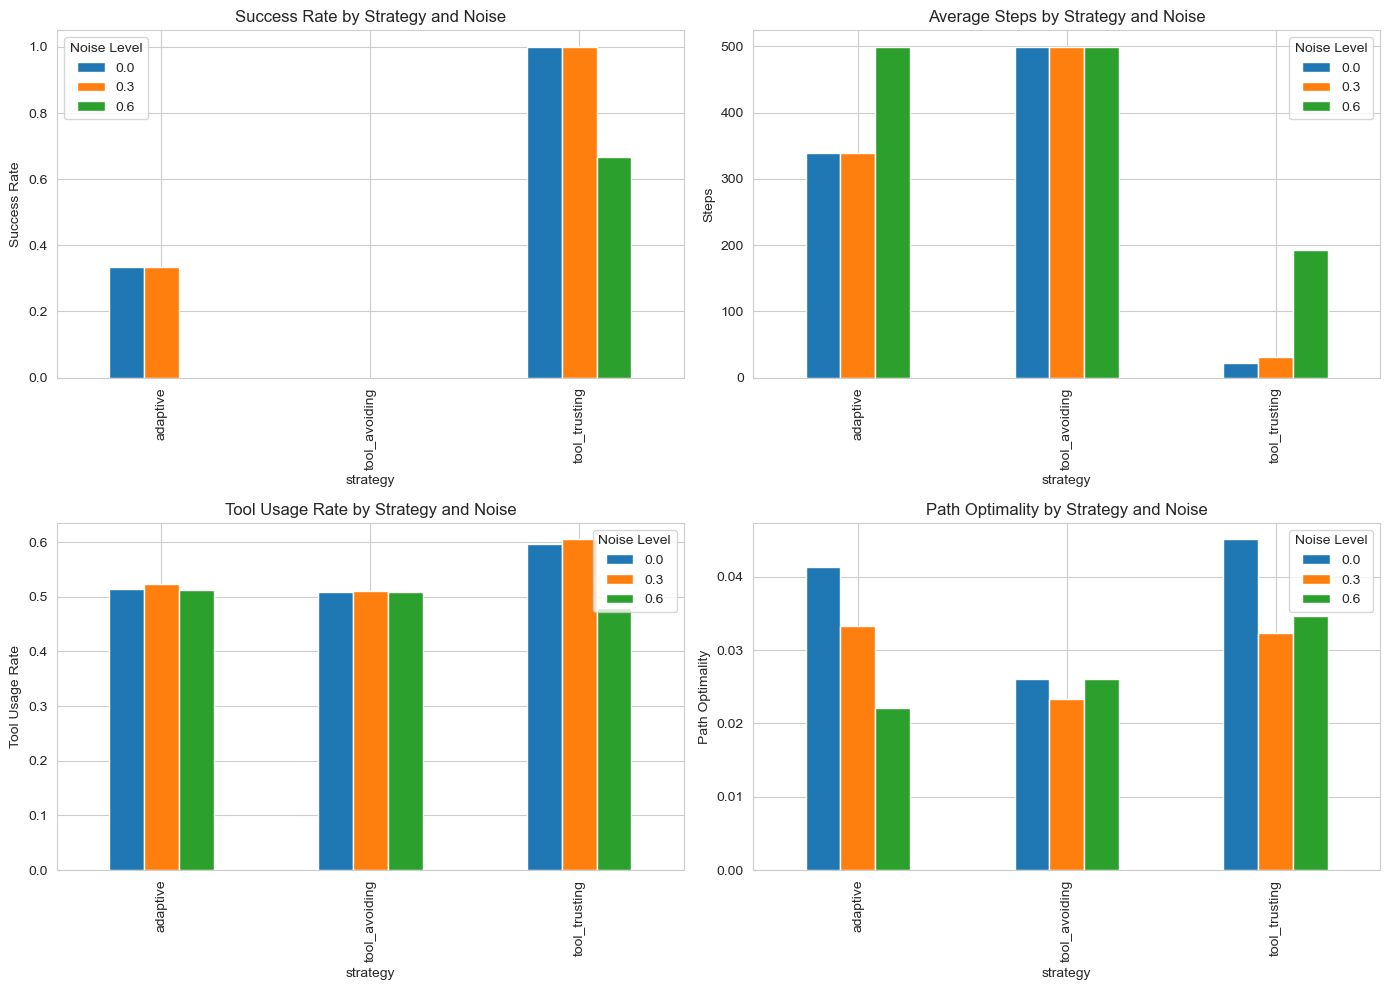


Key Findings:
noise_level      0.0    0.3    0.6
strategy                          
adaptive       0.333  0.333  0.000
tool_avoiding  0.000  0.000  0.000
tool_trusting  1.000  1.000  0.667


In [18]:
# Visualize factorial results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Success rate
pivot_success = df_factorial.pivot_table(
    values='success_rate', 
    index='strategy', 
    columns='noise_level'
)
pivot_success.plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Success Rate by Strategy and Noise')
axes[0, 0].set_ylabel('Success Rate')
axes[0, 0].legend(title='Noise Level')

# Average steps
pivot_steps = df_factorial.pivot_table(
    values='avg_steps',
    index='strategy',
    columns='noise_level'
)
pivot_steps.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Average Steps by Strategy and Noise')
axes[0, 1].set_ylabel('Steps')
axes[0, 1].legend(title='Noise Level')

# Tool usage rate
pivot_tool = df_factorial.pivot_table(
    values='avg_tool_usage_rate',
    index='strategy',
    columns='noise_level'
)
pivot_tool.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Tool Usage Rate by Strategy and Noise')
axes[1, 0].set_ylabel('Tool Usage Rate')
axes[1, 0].legend(title='Noise Level')

# Path optimality
pivot_opt = df_factorial.pivot_table(
    values='avg_path_optimality',
    index='strategy',
    columns='noise_level'
)
pivot_opt.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Path Optimality by Strategy and Noise')
axes[1, 1].set_ylabel('Path Optimality')
axes[1, 1].legend(title='Noise Level')

plt.tight_layout()
plt.show()

print("\nKey Findings:")
print(pivot_success.round(3))

## 6. Key Insights and Conclusions

Based on the pilot experiment, we can analyze LLM overreliance on tools:

In [19]:
# Analyze overreliance patterns
print("\n" + "="*60)
print("OVERRELIANCE ANALYSIS")
print("="*60)

# Compare trusting strategy across noise levels
trusting_results = df_factorial[df_factorial['strategy'] == 'tool_trusting']
print("\nTool-Trusting Strategy (Always follows tool):")
for noise_level in sorted(trusting_results['noise_level'].unique()):
    subset = trusting_results[trusting_results['noise_level'] == noise_level]
    success = subset['success_rate'].mean()
    steps = subset['avg_steps'].mean()
    print(f"  Noise={noise_level:.1f}: Success={success:.1%}, Avg Steps={steps:.1f}")

# Compare adaptive strategy
adaptive_results = df_factorial[df_factorial['strategy'] == 'adaptive']
print("\nAdaptive Strategy (Adjusts tool trust):")
for noise_level in sorted(adaptive_results['noise_level'].unique()):
    subset = adaptive_results[adaptive_results['noise_level'] == noise_level]
    success = subset['success_rate'].mean()
    steps = subset['avg_steps'].mean()
    print(f"  Noise={noise_level:.1f}: Success={success:.1%}, Avg Steps={steps:.1f}")

# Compare avoiding strategy
avoiding_results = df_factorial[df_factorial['strategy'] == 'tool_avoiding']
print("\nTool-Avoiding Strategy (Never uses tool):")
for noise_level in sorted(avoiding_results['noise_level'].unique()):
    subset = avoiding_results[avoiding_results['noise_level'] == noise_level]
    success = subset['success_rate'].mean()
    steps = subset['avg_steps'].mean()
    print(f"  Noise={noise_level:.1f}: Success={success:.1%}, Avg Steps={steps:.1f}")


OVERRELIANCE ANALYSIS

Tool-Trusting Strategy (Always follows tool):
  Noise=0.0: Success=100.0%, Avg Steps=22.3
  Noise=0.3: Success=100.0%, Avg Steps=31.7
  Noise=0.6: Success=66.7%, Avg Steps=192.3

Adaptive Strategy (Adjusts tool trust):
  Noise=0.0: Success=33.3%, Avg Steps=339.7
  Noise=0.3: Success=33.3%, Avg Steps=339.7
  Noise=0.6: Success=0.0%, Avg Steps=499.0

Tool-Avoiding Strategy (Never uses tool):
  Noise=0.0: Success=0.0%, Avg Steps=499.0
  Noise=0.3: Success=0.0%, Avg Steps=499.0
  Noise=0.6: Success=0.0%, Avg Steps=499.0


In [20]:
# Conclusions
print("\n" + "="*60)
print("CONCLUSIONS")
print("="*60)

# Calculate resilience to noise
trusting_at_0 = trusting_results[trusting_results['noise_level'] == 0.0]['success_rate'].mean()
trusting_at_6 = trusting_results[trusting_results['noise_level'] == 0.6]['success_rate'].mean()

adaptive_at_0 = adaptive_results[adaptive_results['noise_level'] == 0.0]['success_rate'].mean()
adaptive_at_6 = adaptive_results[adaptive_results['noise_level'] == 0.6]['success_rate'].mean()

print(f"\nResilience to Noise (0.0 → 0.6):")
print(f"  Tool-Trusting: {trusting_at_0:.1%} → {trusting_at_6:.1%} (Δ = {(trusting_at_6 - trusting_at_0)*100:.1f}pp)")
print(f"  Adaptive:      {adaptive_at_0:.1%} → {adaptive_at_6:.1%} (Δ = {(adaptive_at_6 - adaptive_at_0)*100:.1f}pp)")

print(f"\nOverreliance Indicator:")
if abs(trusting_at_6 - trusting_at_0) > abs(adaptive_at_6 - adaptive_at_0):
    print("  ✓ Tool-trusting strategy shows greater susceptibility to noise")
    print("  ✓ Adaptive strategy better handles unreliable tools")
    print("  ✓ Evidence of overreliance in simple tool-following approach")
else:
    print("  • No significant difference in noise resilience")
    print("  • Further investigation needed")


CONCLUSIONS

Resilience to Noise (0.0 → 0.6):
  Tool-Trusting: 100.0% → 66.7% (Δ = -33.3pp)
  Adaptive:      33.3% → 0.0% (Δ = -33.3pp)

Overreliance Indicator:
  ✓ Tool-trusting strategy shows greater susceptibility to noise
  ✓ Adaptive strategy better handles unreliable tools
  ✓ Evidence of overreliance in simple tool-following approach


## 7. Save Results

Save the experimental results for further analysis.

In [21]:
# Save results
from experiments.results import ResultsAggregator

aggregator = ResultsAggregator(Path('results'))

# Save factorial results
output_csv = aggregator.results_dir / 'pilot_factorial.csv'
df_factorial.to_csv(output_csv, index=False)
print(f"Results saved to {output_csv}")

# Generate summary
summary = {
    'experiment_type': 'pilot_factorial',
    'strategies_tested': strategies,
    'noise_levels': noise_levels,
    'total_experiments': len(df_factorial),
    'best_strategy': df_factorial.loc[df_factorial['success_rate'].idxmax(), 'strategy'],
    'best_success_rate': df_factorial['success_rate'].max(),
}

import json
summary_file = aggregator.results_dir / 'pilot_summary.json'
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"Summary saved to {summary_file}")

Results saved to results/pilot_factorial.csv
Summary saved to results/pilot_summary.json
